# Transfer Learning with TensorFlow : Fine Tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food vision project (using only 10% of original dataset) than building our own model from scratch.

Now, we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained weights from another model are unfrozen and tweaked during to better suit your own data.

*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

> 💡 **This time we will use the helper functions to speed up our steps in learning**

Import the Helper functions

In [ ]:
# Get helper_functions.py script from Github
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves

--2023-01-02 05:04:52--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-02 05:04:52 (55.7 MB/s) - ‘helper_functions.py.1’ saved [2904/2904]



## 10 Food Classes : Working with Less data

As in the previous notebook of Transfer Leanring : Feature Extraction, we got good results from less data (10%) of the training data using transfer learning from TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, `image_dataset_from_directory()` which is a part of `tf.keras.preprocessing` module.

Finally we'll be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The functional API is a more flexible way to create models than the `tf.keras.Sequential`

Let's start by downloading the data

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-01-02 05:04:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.1MB/s    in 7.9s    

2023-01-02 05:05:02 (20.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through the directory and list number of files
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 files in '10_food_classes_10_percent'
There are 10 directories and 0 files in '10_food_classes_10_percent/test'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/fried_rice'
There are 

It's the same number of files and classes we used in previous notebook.

In [ ]:
# Create the training and testing directory
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

Now we've got some image data, we need a way of loading it into a Tensorflow compatible format.

Previously, we've used the `ImageDataGenerator` class. And while this works well and is still very commonly used, this time we're going to use the `image_dataset_from_directory` function.

One of the main benefits of using `tf.keras.preprocessing.image_dataset_from_directory()` rather than `ImageDataGenerator` is that it creates a `tf.data.Dataset` object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much faster and efficient than the `ImageDataGenerator` API which is paramount for larger datasets.



In [ ]:
import tensorflow as tf

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                  image_size=IMG_SHAPE,
                                                  label_mode='categorical',
                                                  batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                 image_size=IMG_SHAPE,
                                                 label_mode='categorical',
                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Wonderful ! Looks like our dataloaders have found the correct number of images for each Dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory` function are:
- `directory`
- `image_size`
- `batch_size`

In [ ]:
# if we check the datatype of the preprocessed dataset
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

It's Batch Dataset

In [ ]:
# check the classes
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example of batch of data, we could use the `take()` method

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[8.34846954e+01 5.44846916e+01 4.04846916e+01]
   [7.75000000e+01 4.90969353e+01 3.50969353e+01]
   [8.37193909e+01 5.57193909e+01 4.17193909e+01]
   ...
   [1.89847244e+02 1.45923767e+02 9.83421860e+01]
   [1.78163345e+02 1.35163345e+02 9.22347870e+01]
   [1.75473892e+02 1.31473892e+02 9.24738922e+01]]

  [[8.05714264e+01 5.37653084e+01 4.11683693e+01]
   [8.20714264e+01 5.57959175e+01 4.29336739e+01]
   [8.04285736e+01 5.44285736e+01 4.10000000e+01]
   ...
   [1.79530502e+02 1.35530502e+02 8.81019745e+01]
   [1.74576630e+02 1.30438858e+02 8.58521576e+01]
   [1.86162918e+02 1.43162918e+02 1.00234344e+02]]

  [[7.66530609e+01 5.38673477e+01 3.98673477e+01]
   [7.80561218e+01 5.52704048e+01 4.14846916e+01]
   [7.53826523e+01 5.25969391e+01 3.88112259e+01]
   ...
   [1.77576202e+02 1.33438461e+02 8.61476669e+01]
   [1.83321442e+02 1.39321442e+02 9.38928604e+01]
   [1.95872269e+02 1.51872269e+02 1.06443687e+02]]

  ...

  [[2.02637756e+02 1.95637756e+02 2.03637756e+02]
   [1

Image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings.

## Model 0. Building a transfer learning model using the Keras Functional API

Alight, our data is tensor-ified, let's build a model.

To do so, we're going to be using the `tf.keras.applications` module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate the pretrained model object by choosing a target model such as `EfficientNetB0` from `tf.keras.applications`, setting the `include_top` to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect ?
4. [Optional] Normalize the inputs to our model if it requires. Some of comp vis models such as `ResNetV250` require their inputs to be between 0 & 1.

In [ ]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-trained weights remain same)
base_model.trainable = False

# 3. Create the inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to our base model
x = base_model(inputs)
# check data shape after passing into base model
print(f'Shape after base_model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'After Global Average Pooling 2D:{x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs into our model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer='Adam',
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=len(test_data_10_percent),
                        callbacks=[create_tensorboard_callback('transfer_learning',
                                                               '10_percent_feature_extraction')])

16705208/16705208 [==============================] - 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After Global Average Pooling 2D:(None, 1280)
Saving Tensorboard log files to: transfer_learning/10_percent_feature_extraction/20230102-050513
Epoch 1/5
24/24 [==============================] - 30s 634ms/step - loss: 1.8327 - accuracy: 0.4133 - val_loss: 1.2662 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 10s 388ms/step - loss: 1.0664 - accuracy: 0.7640 - val_loss: 0.8576 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 9s 370ms/step - loss: 0.7760 - accuracy: 0.8200 - val_loss: 0.6900 - val_accuracy: 0.8344
Epoch 4/5
24/24 [==============================] - 8s 325ms/step - loss: 0.6303 - accuracy: 0.8573 - val_loss: 0.6037 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 9s 354ms/step - loss: 0.5402 - accuracy: 0.8773 - val_loss: 0.5493 - val_accuracy: 0.8620


Alright, we get 88% Training accuracy and 86% Validation accuracy. Not Bad !

Next would be to plot the loss curves using Helper Function,

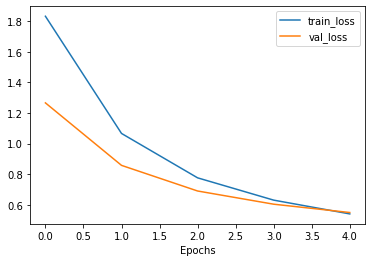

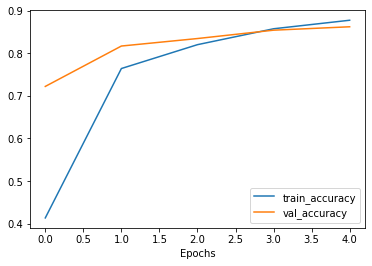

In [ ]:
# plotting the loss and accuracy curves
plot_loss_curves(history_0)

It looks like if we increase the number of `epochs` or leave our model to train little longer we might achieve more decrease in loss since it's continously decreasing which is good sign, and vice-versa for accuracy, accuracy curve is almost touching 0.9

It's important to note the kind of transfer learning we used here is feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetB0`), asked it "What patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of clases.


We have also used the Keras Functional API to build our model rather than Sequential API. For now, the benefits of this may not seem clear but when start building more sophistictaed modesl, you'll probably want to use the Functional API. So it's important to get familiar now.

> 💡 **What I assume** : *If we use **Functional API** for transfer learning models, due to it's flexibility we can alter anything according to our own problem which I guess would be helpful in fine-tuning*.


Let's inspect the model layers, we'll start with the base.

In [ ]:
# check the layers in our base_model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

So these are the list of layers that are used in the pre-trained `base_model`.
These are hand-coded by the creators of these model adding each layer manually and tested on `ImageNet` dataset. But transfer-learning makes it available for us to use this in our own dataset.


How about the summary of the `base_model`?

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

Here if we notice `Trainable params : 0`, because we haven't trained or changed anything on the patterns or weights, we just did feature extraction, and the layers are unfrozen that's why.

We did this by setting `base_model.trainable = False`.

Alright that was the `base_model`, let's see the summary of our overall model.

In [ ]:
# check the summary of overall model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has 4 layers, but one of those layers (`efficientnetb0`) has 236 layers.

We can also see the output shape of our input_layer is `(None, 224, 224, 3)` but was transformed to `(None, 10)` in the output_layer (shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable params are equal to the params in output_layer, which means we adjusted only the output layer based on our own dataset in this feature extracted model.

We are discussing from the last notebook about the feature vectors but haven't really see in practice, how actually it looks like, so let's find.

## Getting a feature vector from a trained model

**What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer?**

The `tf.keras.layers.GlobalAveragePooling2D()` layer transforms a 4D tensor into 2D tensor by averaging the values across the inner-axes.

If we see the `model.summary()`, we have 2nd layer as `efficientnetb0` with output shape as `(None, None, None, 1280)` but after applying `tf.keras.layers.GlobalAveragePooling2D` layer, it transforms that into `(None, 1280)`.

Let's see an example, how does it do.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(17)
input_tensor = tf.random.normal(input_shape)
print(f"Random Input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooling random tensor:\n {global_average_pooling_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D Global Average Pooled input tensor: {global_average_pooling_tensor.shape}")

Random Input tensor:
 [[[[ 0.01778085  2.3094206  -0.9550922 ]
   [-1.7634275   0.4548187  -0.18493938]
   [-0.35161677  0.18182382 -0.31690374]
   [-0.15134323 -0.07775787  0.17686777]]

  [[ 0.21436396  0.1932961   1.4182636 ]
   [-0.8006435  -0.70749104 -1.2525052 ]
   [ 0.02151339  0.34174567 -1.2530284 ]
   [-0.17276597  0.16387203 -0.80704546]]

  [[ 0.62522286 -1.5750551  -0.0113454 ]
   [-2.2971196   1.3553604  -0.75843495]
   [ 0.37949955 -1.5703921  -0.04764017]
   [ 0.46110848  1.0848212  -1.0602777 ]]

  [[ 0.05737554 -0.88729954  0.8313546 ]
   [-0.18021747 -1.0707239  -0.41009685]
   [ 1.0844605  -0.04417734 -1.1369785 ]
   [-1.3155755   1.670021   -1.1997223 ]]]]

2D global average pooling random tensor:
 [[-0.26071152  0.11389266 -0.43547028]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D Global Average Pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging `input_tensor` across the middle two axes.

We can replicate this operator using `tf.reduce_mean()` operation and specifying the appropriate axes.

In [ ]:
tf.reduce_mean(input_tensor, axis=[1,2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.26071152,  0.11389266, -0.43547028]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer(`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same thing with `tf.keras.layers.GlobalMaxPooling2D()`

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of data ?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves ?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer leaning on 1% of the training data with data augmentation
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All the experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instread of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using `tf.keras.layers.experimental.preprocessing` module.

Let's begin by downloading the 1% of training dataset of food vision,

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-01-02 05:06:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.5MB/s    in 6.4s    

2023-01-02 05:06:47 (19.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



Walking through the directory

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 files in '10_food_classes_1_percent'
There are 10 directories and 0 files in '10_food_classes_1_percent/test'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/steak'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/ice_cream'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/hamburger'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/chicken_wings'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/chicken_curry'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/pizza'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/grilled_salmon'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/ramen'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/sushi'
There are 0 directories and 250 files in '10_food_classes_1_percent/test/fried_rice'
There are 10 directori

So we have 7 images per class in training set for directory `10_food_classes_1_percent` and test set are still the same

Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the `image_dataset_from_directory()` method

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Data Loaded, Time to augment it.

### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How ?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layers to the model has the following benefits:
- Preprocessing of the images(augmenting them) happens on the GPU rather than on the CPU(much faster)
  - Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
- Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

The data augmentation transformations we're going to use are:
- [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip)
- [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation)
- [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom)
- [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight)
- [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth)
- [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling)

There are more options but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescaling(1./255) # Keep for ResNet50V2, remove for EfficientNetB0
], name='data_augmentation')

And that's it! Our data augmentation Sequential model is ready to go. As you'll see shortly, we'll be able to slot this "model" as a layer into our transfer learning model later on.

But before we do that, let's test it out by passing random images through it.

Text(0.5, 1.0, 'Augmented random image from class: hamburger')

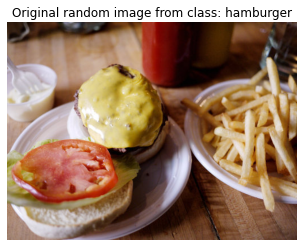

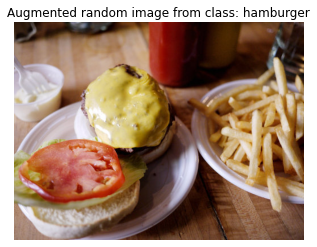

In [ ]:
# view a random image
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = '10_food_classes_1_percent/train/'+ target_class # create the target directry

random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img) # plot the image
plt.axis(False)
plt.title(f"Original random image from class: {target_class}");

plt.figure()
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.axis(False)
plt.title(f"Augmented random image from class: {target_class}")

### Model 1 : Feature Extraction Transfer Learning with 1% of the data with Data Augmentation

In [ ]:
# Setup input shape and base model, freeezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x= layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax",name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer='Adam',
                metrics=['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)), # validate for less steps
                                callbacks=[create_tensorboard_callback('transfer_learning', "1_percent_data_aug")])

Saving Tensorboard log files to: transfer_learning/1_percent_data_aug/20230102-050652
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.3886 - accuracy: 0.1143 - val_loss: 2.2002 - val_accuracy: 0.2105
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1188 - accuracy: 0.2429 - val_loss: 2.0748 - val_accuracy: 0.3191
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 1.9474 - accuracy: 0.3714 - val_loss: 1.9530 - val_accuracy: 0.3947
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7441 - accuracy: 0.5429 - val_loss: 1.8653 - val_accuracy: 0.4293
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5920 - accuracy: 0.6429 - val_loss: 1.7567 - val_accuracy: 0.4885


If we check out the summary of our model, we should see the data augmentation layer just after the input layer

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

Since we freeze the layers of the efficientnetb0 model, only output layer has trainable params i.e 12810

In [ ]:
# evaluate the model in all test set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 98ms/step - loss: 1.7544 - accuracy: 0.4992


[1.7544012069702148, 0.4991999864578247]

Let's check out our model's loss curves

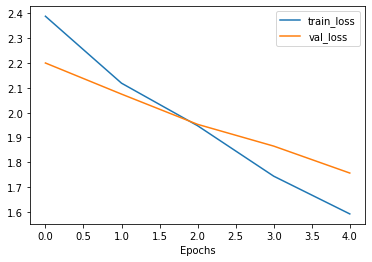

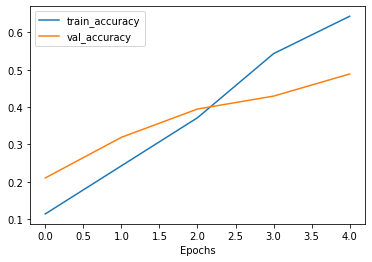

In [ ]:
plot_loss_curves(history_1_percent)

### Model 2: Feature Extraction Transfer Learning with 10% of the data and data augmentation

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-01-02 05:07:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 7.8s    

2023-01-02 05:07:53 (20.7 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Walking through the directory
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 files in '10_food_classes_10_percent'
There are 10 directories and 0 files in '10_food_classes_10_percent/test'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/fried_rice'
There are 

In [ ]:
# Load the data using keras.preprocessing.image
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir_10_percent = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                                                     label_mode='categorical',
                                                     image_size=(224, 224),
                                                     batch_size=32)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode='categorical',
                                         image_size=(224, 224),
                                         batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Create a data augmentation layer again for 10% dataset, it's not required again, we can reuse the layer that we created for 1% data but this is for practice

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_model_2 = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    # rescaling not needed for EfficientNetB0
], name='data_augmentation_model_2')

In [ ]:
# Input shape to our model
input_shape = (224, 224, 3)

# Create the base_model and freeze the layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name='input_layer') # Create input layer
x = data_augmentation_model_2(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = keras.Model(inputs, outputs)

# compile
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

If we notice above, we have set `base_model(x, training=False)`, by setting up `training=False` means that we are saying base_model to run on inference mode and so that batchnormalization layers don't get updated even after we unfreeze the base model for fine-tuning.

https://keras.io/guides/transfer_learning/#build-a-model

Next our model is compiled and ready to fit, but before that we'll create a modelcheckpoint callback.

#### Creating a ModelCheckpoint callback

The [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [SavedModel](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights(patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.


In fact, that's exactly what we're going to do.

Let's create `ModelCheckpoint` callback first,

In [ ]:
# setup checkpoint path
checkpoint_path = '10_percent_model_checkpoints_weights/checkpoint.cpkt'

# Create a modelcheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_best_only=False, # set True if you want to save only best model
                                                         save_weights_only=True, # set to false to save the entire model
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

> 🤔 **Question**: What is the difference between Saving the entire model (SavedModel format) and saving the weights only ?

The [SavedModel](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epoch` and set it to 5.


In [ ]:
# fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                 "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving Tensorboard log files to: transfer_learning/10_percent_data_aug/20230102-050758
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9368 - accuracy: 0.3693
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.cpkt
24/24 [==============================] - 23s 633ms/step - loss: 1.9368 - accuracy: 0.3693 - val_loss: 1.4189 - val_accuracy: 0.6859
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2793 - accuracy: 0.7053
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.cpkt
24/24 [==============================] - 13s 527ms/step - loss: 1.2793 - accuracy: 0.7053 - val_loss: 0.9952 - val_accuracy: 0.7697
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9705 - accuracy: 0.7667
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.cpkt
24/24 [==============================] - 11s 428ms/step - loss: 0.9705 - accuracy: 0.7667 - val_loss: 0.8043 - val_accuracy: 0.8158
Epoc

Looks like our `ModelCheckpoint` worked and our model saved its weights every epoch without too much overhead (saving the whole model takes longer than just the weights)

Let's evaluate our model and check its loss curves.

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 103ms/step - loss: 0.6234 - accuracy: 0.8408


[0.6234309673309326, 0.8407999873161316]

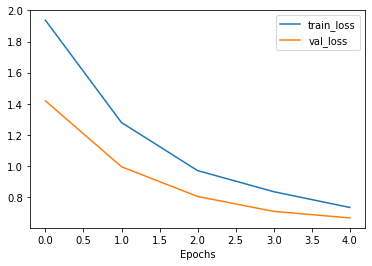

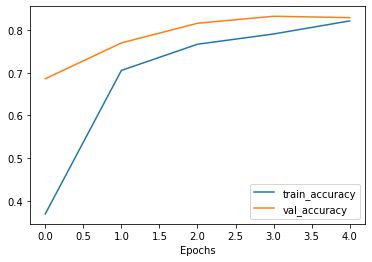

In [ ]:
# Plot the loss curves
plot_loss_curves(history_10_percent_data_aug)

To load saved weights you can use the `load_weights()` method, passing it the path where your saved weights are stored.

In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.6234 - accuracy: 0.8408


In [ ]:
results_10_percent_data_aug

[0.6234309673309326, 0.8407999873161316]

If we compare both the results,

In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

False

It's showing False because of the decimal precision but if use a function called `np.isclose` which compare based on tolerence, we can verify that,

In [ ]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-2.98023224e-07  0.00000000e+00]


### Model 3: Fine-Tuning an existing model on 10% of the data

*High-level example of fine-tuning an EfficientNet model. Bottom Layers(layers closer to input data) stay frozen where as top layers(layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers of Base Model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note**: Fine tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras guide on Transfer Leanrning & fine-tuning](https://keras.io/guides/transfer_learning/)

We've verified our loaded model's performance, let's check out its layers.

In [ ]:
# Layers in loaded model
model_2.layers

So we can see have 5 main layers, which are in order as,
- Input Layer which have the input shape
- Sequential Layer, responsible for data augmentation with our inputs
- Functional API Layer, contains the base model
- GlobalAveragePooling2D layer for feature extraction, it extracted the features from the base model
- Dense layer is our output layer

If we see which layer is trainable and which not

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


How about the summary?

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_model_2 (  (None, 224, 224, 3)      0         
 Sequential)                                                     
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

It looks like all the layers in the `efficientnetb0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

In [ ]:
print(len(base_model.trainable_variables))

0


We can even check layer by layer to see if they're trainable.

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

Now, to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> **Question**: How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource**: The [ULMFiT (Universal Language Model Fine-tuning](https://arxiv.org/abs/1801.06146) for Text Classification) paper has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

In [ ]:
base_model.trainable = True

# Freeze all layers except for the top 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)) # lr is 10x lower than before for fine-tuning

Now, let's check which layers of the pretrained model are trainable.

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

Nice it seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

> **Question**: Why did we recompile the model ?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before(0.0001 instead of Adam's default 0.001)

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

> 🔑 Note: There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+](https://arxiv.org/abs/1801.06146) seem to work well in practice.



In [ ]:
# how many trainable variable we have now?
print(len(model_2.trainable_variables))

12


Wonderful, it looks like our model has a total of 10 trainable variable, the 10 layers of the base model and the weight and bias parameters of dense output layer.

Time to fine-tune !

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another epochs.

To do this, we can use `initial_epoch` paramter of the `fit()` method.

In [ ]:
# fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               validation_steps = int(0.25* len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving Tensorboard log files to: transfer_learning/10_percent_fine_tune_last_10/20230102-050954
Epoch 5/10
24/24 [==============================] - 26s 659ms/step - loss: 0.6144 - accuracy: 0.8387 - val_loss: 0.5116 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 11s 446ms/step - loss: 0.4801 - accuracy: 0.8493 - val_loss: 0.5031 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 10s 406ms/step - loss: 0.4133 - accuracy: 0.8787 - val_loss: 0.4482 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 10s 394ms/step - loss: 0.4009 - accuracy: 0.8787 - val_loss: 0.4565 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 10s 398ms/step - loss: 0.3471 - accuracy: 0.9027 - val_loss: 0.4330 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 12s 466ms/step - loss: 0.2958 - accuracy: 0.9107 - val_loss: 0.4746 - val_accuracy: 0.8520


Great ! We achieved the highest training accuracy percentage after fine-tuning our model.

Let's evaluate with all test data,

In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.4202 - accuracy: 0.8608


Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare before and after ?


In [ ]:
import matplotlib.pyplot as plt

def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two histories objects of a model
  """

  # get the original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history with new history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']


  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning") # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')


  # Make plot for loss
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning") # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.xlabel('epoch')
  plt.show();

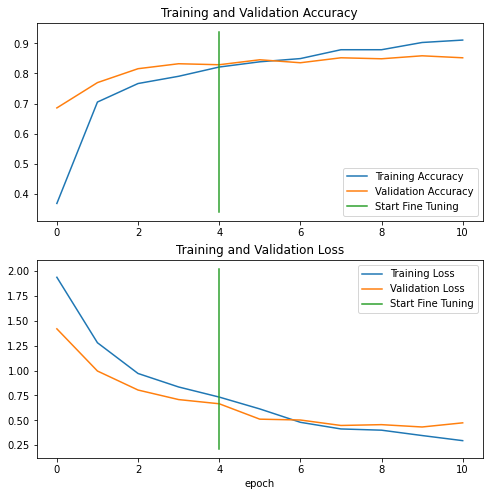

In [ ]:
compare_histories(original_history = history_10_percent_data_aug,
                  new_history = history_fine_10_percent_data_aug,
                  initial_epochs=5)

Alright, seems like the curves are heading into the right direction after fine-tuning, But remember, it should be noted that **fine-tuning usually works best with larger amount of data and feature extraction works lesser amount of data**.

### Model 4 : Fine-Tuning an existing model all of the data

We'll start by downloading the full version of our 10 food classes dataset.

In [ ]:
# Download and unzip 10 classes of data of all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-01-02 05:11:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.6MB/s    in 23s     

2023-01-02 05:12:06 (21.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now ?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 files in '10_food_classes_all_data'
There are 10 directories and 0 files in '10_food_classes_all_data/test'
There are 0 directories and 250 files in '10_food_classes_all_data/test/steak'
There are 0 directories and 250 files in '10_food_classes_all_data/test/ice_cream'
There are 0 directories and 250 files in '10_food_classes_all_data/test/hamburger'
There are 0 directories and 250 files in '10_food_classes_all_data/test/chicken_wings'
There are 0 directories and 250 files in '10_food_classes_all_data/test/chicken_curry'
There are 0 directories and 250 files in '10_food_classes_all_data/test/pizza'
There are 0 directories and 250 files in '10_food_classes_all_data/test/grilled_salmon'
There are 0 directories and 250 files in '10_food_classes_all_data/test/ramen'
There are 0 directories and 250 files in '10_food_classes_all_data/test/sushi'
There are 0 directories and 250 files in '10_food_classes_all_data/test/fried_rice'
There are 10 directories and 0 fil

And now we'll turn the images into tensors datasets.

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We've got 10x more images on training classes to work with.

The **test dataset is the same** we've been using for our previous experiment.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

In [ ]:
# evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.4202 - accuracy: 0.8608


[0.4201902747154236, 0.86080002784729]

These are the same values as `results_fine_tune_10_percent`

In [ ]:
results_fine_tune_10_percent

[0.4201902449131012, 0.86080002784729]

Now we'll revert the model back to the saved weights

In [ ]:
# load model from checkpoint, that way we can fine-tune from the same stafe the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

And the results should be the same as `results_10_percent_data_aug`

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.6234 - accuracy: 0.8408


[0.6234313249588013, 0.8407999873161316]

In [ ]:
results_10_percent_data_aug

[0.6234309673309326, 0.8407999873161316]

Hence, we have reverted the fine-tuned model on 10% data to feature extracted stage.

So far we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the weights using `ModelCheckpoint`
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2 ?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are trainable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_model_2 True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


Can we get a little more specific ?


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

The last 10 layers are trainable (unfrozen)

We need re-compile the model because we Reloaded the weights.

In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Alright, time to fine-tune on all of the data!

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_tune_full_data =  model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                  "full_10_classes_fine_tune_last_10")])

Saving Tensorboard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230102-054748
Epoch 5/10
235/235 [==============================] - 74s 285ms/step - loss: 0.6451 - accuracy: 0.7927 - val_loss: 0.3496 - val_accuracy: 0.9030
Epoch 6/10
235/235 [==============================] - 54s 229ms/step - loss: 0.5219 - accuracy: 0.8333 - val_loss: 0.2918 - val_accuracy: 0.9030
Epoch 7/10
235/235 [==============================] - 50s 213ms/step - loss: 0.4565 - accuracy: 0.8540 - val_loss: 0.3240 - val_accuracy: 0.8997
Epoch 8/10
235/235 [==============================] - 47s 198ms/step - loss: 0.4214 - accuracy: 0.8613 - val_loss: 0.2441 - val_accuracy: 0.9276
Epoch 9/10
235/235 [==============================] - 45s 190ms/step - loss: 0.3904 - accuracy: 0.8721 - val_loss: 0.2571 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 43s 182ms/step - loss: 0.3630 - accuracy: 0.8808 - val_loss: 0.2752 - val_accuracy: 0.9112


Let's evaluate on all of the test data.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 74ms/step - loss: 0.2684 - accuracy: 0.9136


[0.2683623433113098, 0.9136000275611877]

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look like ?


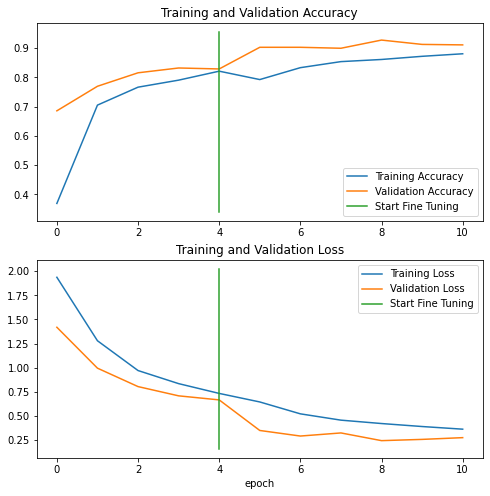

In [ ]:
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_tune_full_data,
                  initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot

Experiment URL : https://tensorboard.dev/experiment/3uRZ8fzaRVO7rkr4GR0t0g/

In [ ]:
# To delete an experiment,
# !tensorboard dev delete --experiment_id 3uRZ8fzaRVO7rkr4GR0t0g